In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, accuracy_score, roc_curve, roc_auc_score
import numpy as np
import keras
import matplotlib.pyplot as plt

In [2]:
def save_model(model, path):
    model.save(path)
    # converter = tf.lite.TFLiteConverter.from_saved_model(path)
    # tflite_model = converter.convert()
    # open(path+".tflite", "wb+").write(tflite_model)

In [3]:
SEQ_SIZE = 151

fontsize = 24
train_file_path = "train_data.csv"

df = pd.read_csv(train_file_path)
df = df.sample(frac = 1)

split_data = int(df.shape[0]*0.8)
train_data = df[:split_data]
test_data = df[split_data:]
train_labels = train_data.pop(train_data.columns[0])
train_labels_cat = to_categorical(train_labels, num_classes=2)
train_data = to_categorical(train_data.values.reshape(train_data.shape[0], SEQ_SIZE, 1), num_classes=4)
test_labels = test_data.pop(test_data.columns[0])
test_labels_cat = to_categorical(test_labels, num_classes=2)
test_data = to_categorical(test_data.values.reshape(test_data.shape[0], SEQ_SIZE, 1), num_classes=4)

In [4]:
def get_compiled_model():
    input_layer = tf.keras.layers.Input(batch_shape=(None, SEQ_SIZE, 4), name='input')
    conv_layer_1 = tf.keras.layers.Conv1D(filters=32, kernel_size = 3, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(input_layer)
    bn_1 = tf.keras.layers.BatchNormalization()(conv_layer_1)
    conv_layer_2 = tf.keras.layers.Conv1D(filters=32, kernel_size = 5, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(bn_1)
    bn_2 = tf.keras.layers.BatchNormalization()(conv_layer_2)
    avg_pool_1 = tf.keras.layers.AvgPool1D(pool_size = 2)(bn_2)
    dp_1 = tf.keras.layers.Dropout(0.5)(avg_pool_1)
    conv_layer_3 = tf.keras.layers.Conv1D(filters=64, kernel_size = 3, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(dp_1)
    bn_3 = tf.keras.layers.BatchNormalization()(conv_layer_3)
    conv_layer_4 = tf.keras.layers.Conv1D(filters=64, kernel_size = 5, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(bn_3)
    bn_4 = tf.keras.layers.BatchNormalization()(conv_layer_4)
    avg_pool_2 = tf.keras.layers.AvgPool1D(pool_size = 2)(bn_4)
    dp_2 = tf.keras.layers.Dropout(0.5)(avg_pool_2)
    conv_layer_5 = tf.keras.layers.Conv1D(filters=128, kernel_size = 3, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(dp_2)
    bn_5 = tf.keras.layers.BatchNormalization()(conv_layer_5)
    conv_layer_6 = tf.keras.layers.Conv1D(filters=128, kernel_size = 5, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(bn_5)
    bn_6 = tf.keras.layers.BatchNormalization()(conv_layer_6)
    avg_pool_3 = tf.keras.layers.AvgPool1D(pool_size = 2)(bn_6)
    dp_3 = tf.keras.layers.Dropout(0.5)(avg_pool_3)
    conv_layer_7 = tf.keras.layers.Conv1D(filters=256, kernel_size = 3, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(dp_3)
    bn_7 = tf.keras.layers.BatchNormalization()(conv_layer_7)
    conv_layer_8 = tf.keras.layers.Conv1D(filters=256, kernel_size = 5, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(bn_7)
    bn_8 = tf.keras.layers.BatchNormalization()(conv_layer_8)
    avg_pool_4 = tf.keras.layers.AvgPool1D(pool_size = 2)(bn_8)
    dp_4 = tf.keras.layers.Dropout(0.5)(avg_pool_4)
    # conv_layer_9 = tf.keras.layers.Conv1D(filters=256, kernel_size = 5, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(dp_4)
    # bn_9 = tf.keras.layers.BatchNormalization()(conv_layer_9)
    # conv_layer_10 = tf.keras.layers.Conv1D(filters=256, kernel_size = 7, activation=tf.nn.relu6, strides=1, kernel_regularizer='L1L2')(bn_9)
    # bn_10 = tf.keras.layers.BatchNormalization()(conv_layer_10)
    # avg_pool_5 = tf.keras.layers.AvgPool1D(pool_size = 2)(bn_10)
    # dp_5 = tf.keras.layers.Dropout(0.5)(avg_pool_5)
    flat_1 = tf.keras.layers.Flatten()(dp_4)
    res_1 = tf.keras.layers.Reshape((1, flat_1.shape[1]))(flat_1)
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=1024, activation='relu', return_sequences=False))(res_1)
    flat_2 = tf.keras.layers.Flatten()(lstm_1)
    dense_1 = tf.keras.layers.Dense(units=1024, activation='relu')(flat_2)
    dense_2 = tf.keras.layers.Dense(2, activation='softmax')(dense_1)
    model = tf.keras.models.Model(inputs = input_layer, outputs = dense_2)
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss=tf.losses.categorical_crossentropy, metrics=['categorical_accuracy'])
    model.summary()
    return model

In [5]:
model = get_compiled_model()
# model = tf.saved_model.load("model")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 151, 4)]          0         
                                                                 
 conv1d (Conv1D)             (None, 149, 32)           416       
                                                                 
 batch_normalization (BatchN  (None, 149, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 145, 32)           5152      
                                                                 
 batch_normalization_1 (Batc  (None, 145, 32)          128       
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, 72, 32)           0     

In [6]:
early = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_categorical_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [early, redonplat, tf.keras.callbacks.TensorBoard('logs')]

In [7]:
hist = model.fit(train_data, train_labels_cat, epochs=100, validation_split=0.20, batch_size=32, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
285/285 [==============================] - 35s 80ms/step - loss: 0.5232 - categorical_accuracy: 0.7482 - val_loss: 0.4645 - val_categorical_accuracy: 0.7881 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 15s 51ms/step - loss: 0.4264 - categorical_accuracy: 0.8124 - val_loss: 0.3486 - val_categorical_accuracy: 0.8631 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 10s 37ms/step - loss: 0.3849 - categorical_accuracy: 0.8358 - val_loss: 0.4244 - val_categorical_accuracy: 0.8477 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 13s 46ms/step - loss: 0.3721 - categorical_accuracy: 0.8447 - val_loss: 0.2890 - val_categorical_accuracy: 0.8811 - lr: 0.0010
Epoch 5/100
285/285 [==============================] - 11s 40ms/step - loss: 0.3388 - categorical_accuracy: 0.8625 - val_loss: 0.2637 - val_categorical_accuracy: 0.8995 - lr: 0.0010
Epoch 6/100
285/285 [==============================] - 11s 38ms/step - loss: 0.3101 - cate

In [8]:
pred_test = np.argmax(model.predict(test_data), axis = 1)
accuracy = accuracy_score(test_labels, pred_test)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.9357443820224719


In [9]:
cf_m = tf.math.confusion_matrix(test_labels, pred_test, num_classes=2)
print(cf_m)

tf.Tensor(
[[1313  103]
 [  80 1352]], shape=(2, 2), dtype=int32)


In [10]:
save_model(model, "model")

INFO:tensorflow:Assets written to: model\assets


In [11]:
recall = precision_recall_fscore_support(test_labels, pred_test, average="binary")
print('Precision: {0:0.2f}'.format(recall[0]))
print('Recall: {0:1.2f}'.format(recall[1]))
print('F1-Score: {0:2.2f}'.format(recall[2]))

Precision: 0.93
Recall: 0.94
F1-Score: 0.94


In [12]:
pred_test = np.argmax(model.predict(test_data), axis = 1)
pred_test = to_categorical(pred_test)
ns_auc = roc_auc_score(test_labels_cat[:, 0], pred_test[:, 0])
lr_auc = roc_auc_score(test_labels_cat[:, 1], pred_test[:, 1])
print('Non-Promoter: ROC AUC=%.3f' % (ns_auc))
print('Promoter: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(test_labels_cat[:, 0], pred_test[:, 0])
lr_fpr, lr_tpr, _ = roc_curve(test_labels_cat[:, 1], pred_test[:, 1])

Non-Promoter: ROC AUC=0.936
Promoter: ROC AUC=0.936


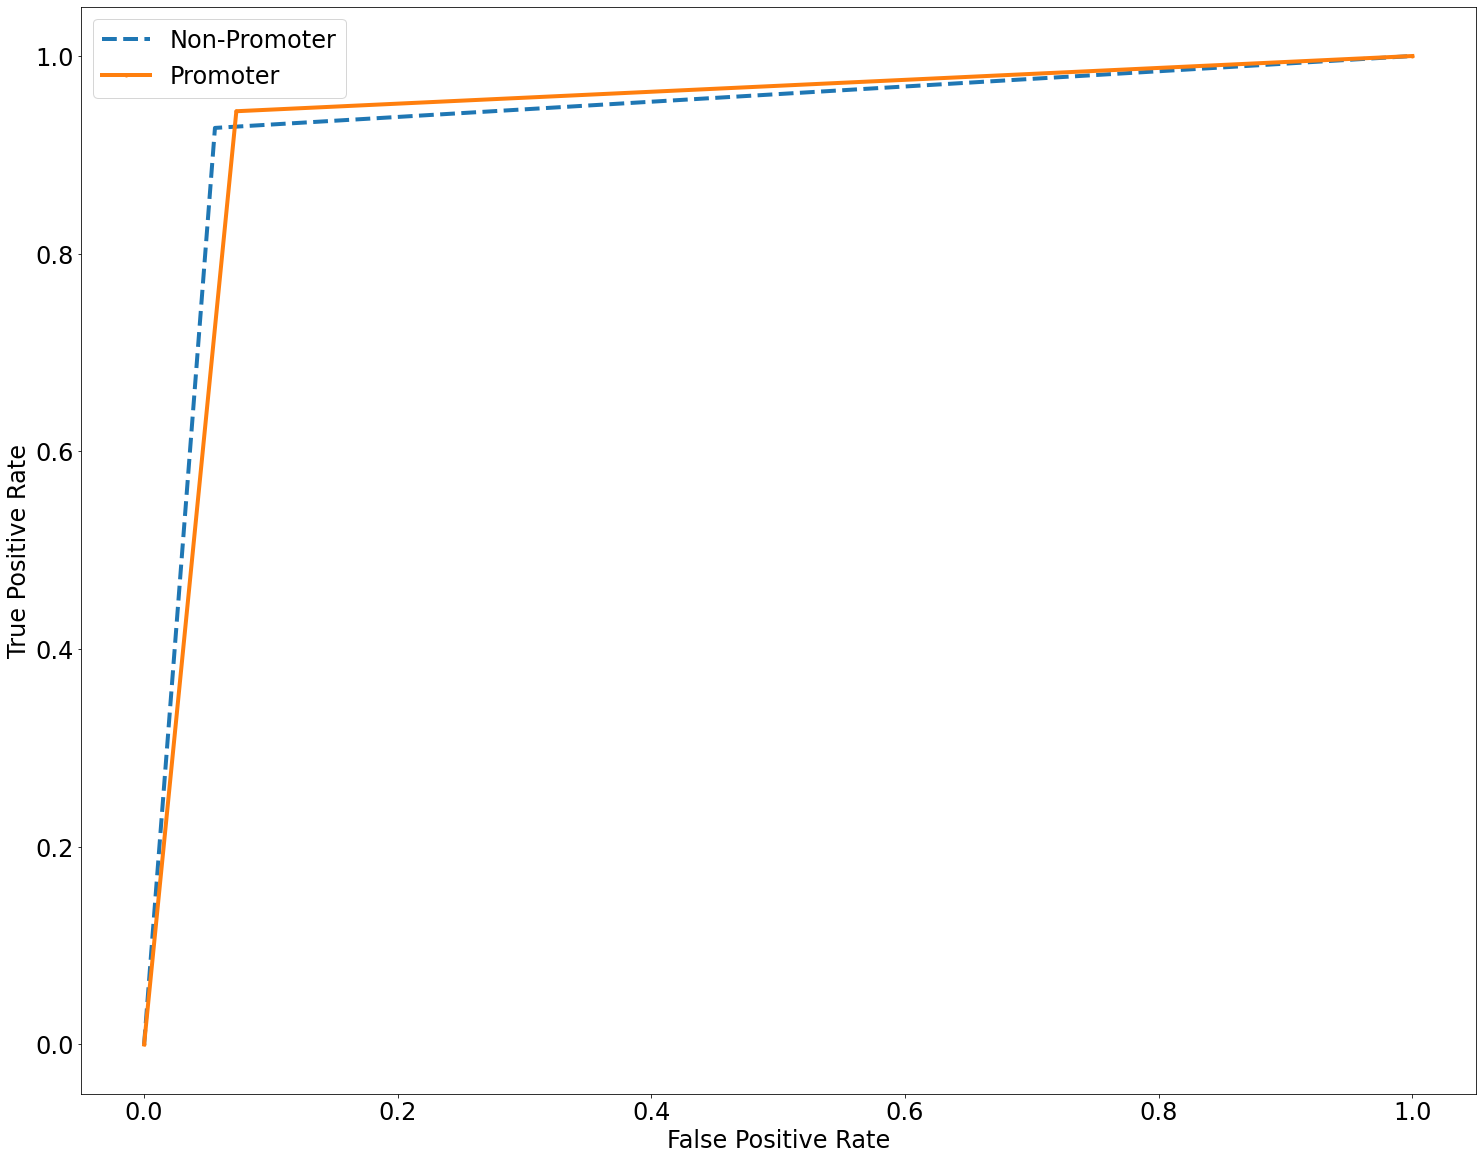

In [13]:
fig = plt.figure(figsize=(25, 20))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Non-Promoter', linewidth=4)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Promoter', linewidth=4)
plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.savefig("roc150.png")

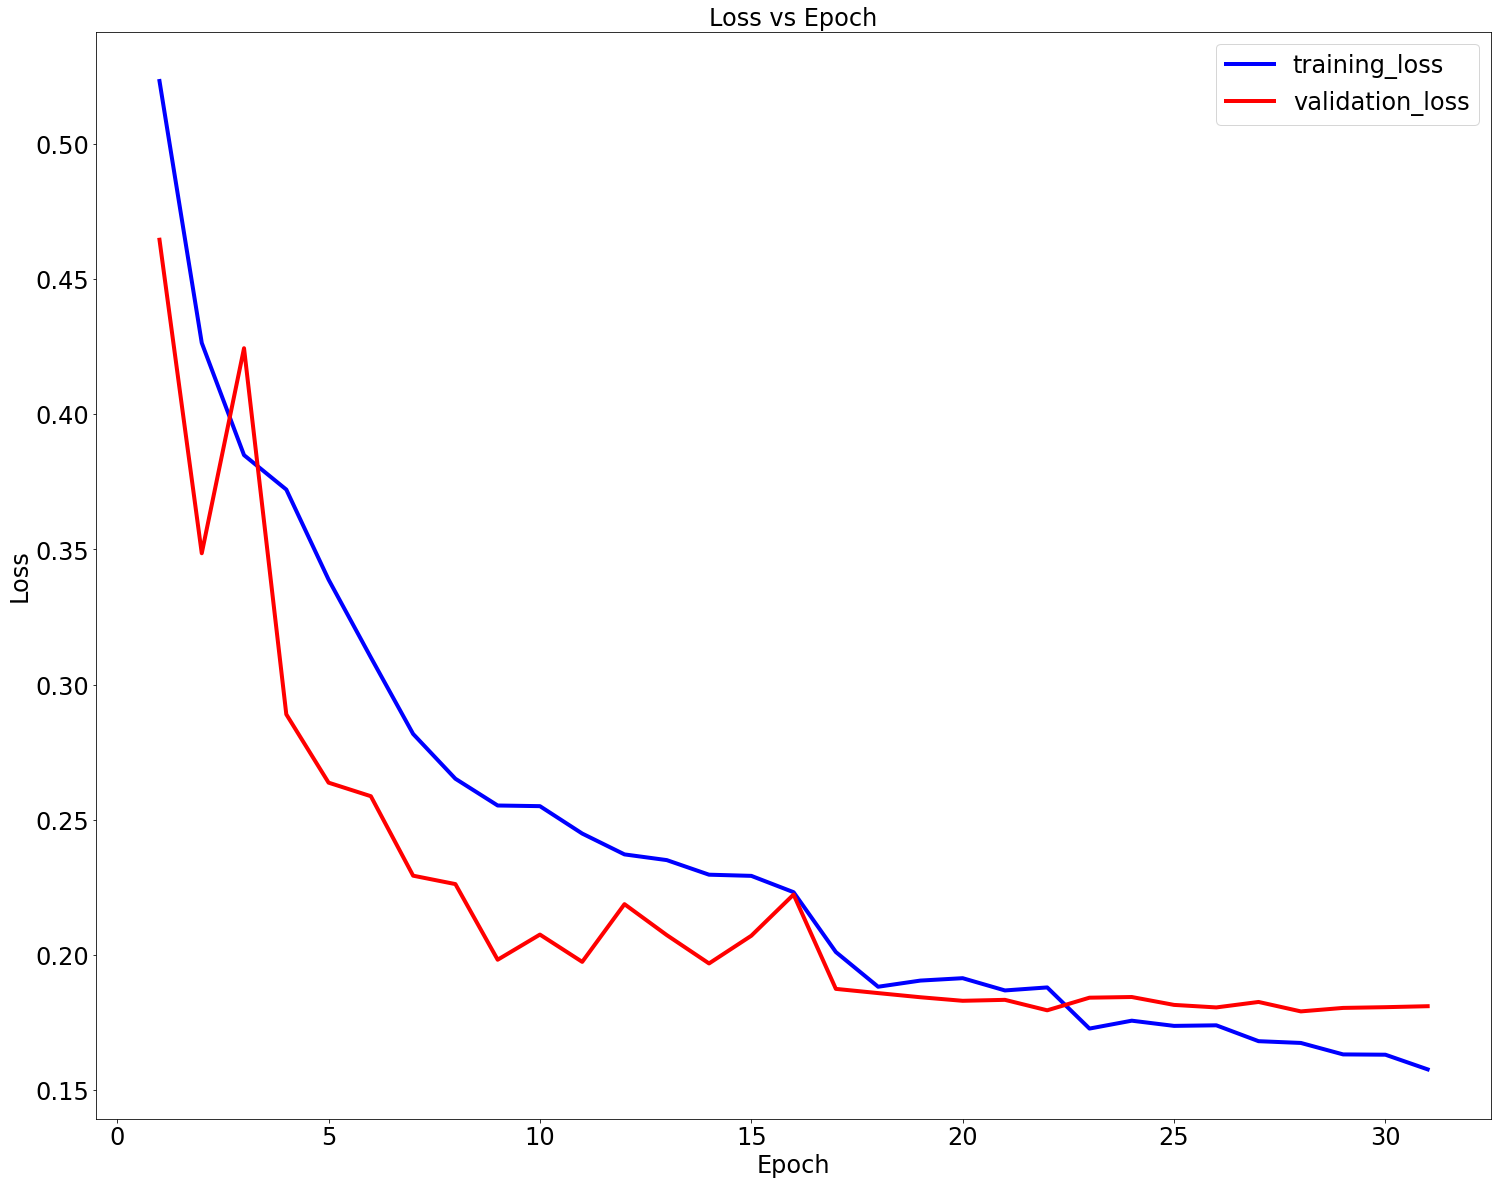

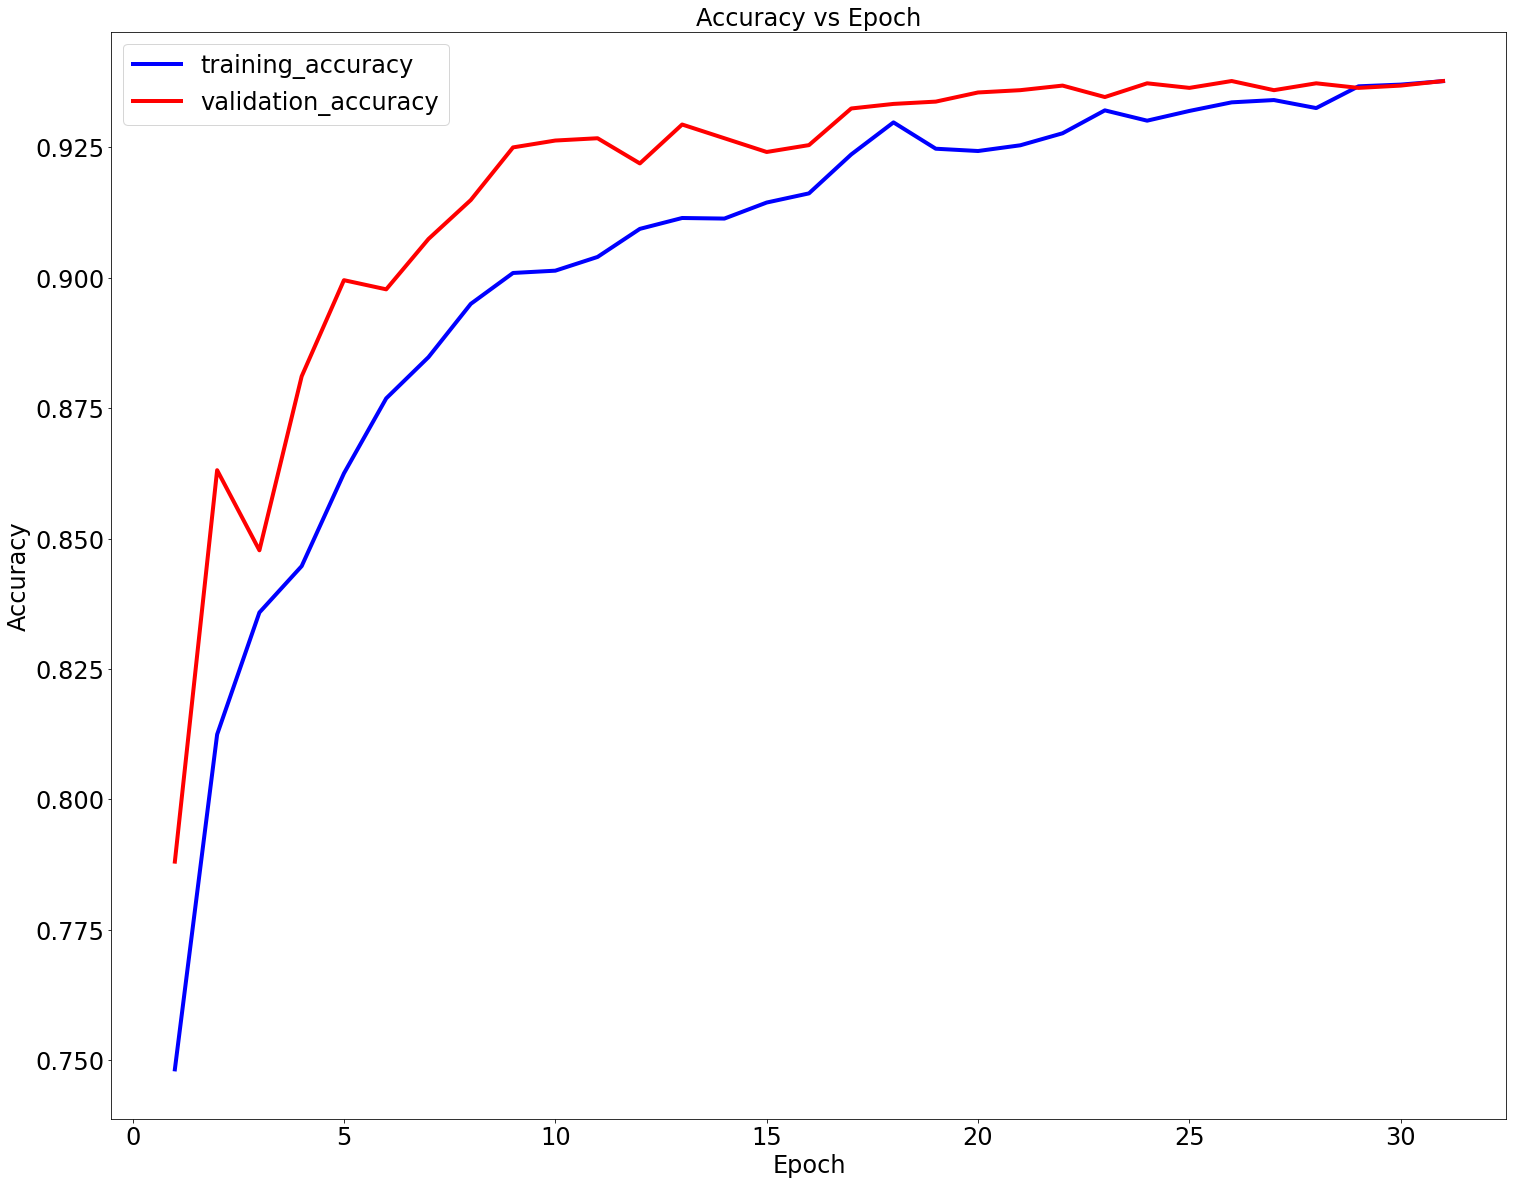

In [14]:
summ = hist.history

epochs = [i for i in range(1, len(summ['loss'])+1)]

fig = plt.figure(figsize=(25, 20))
plt.plot(epochs, summ['loss'], color='blue', label="training_loss", linewidth=4)
plt.plot(epochs, summ['val_loss'], color='red', label="validation_loss", linewidth=4)
plt.legend(loc='best', fontsize=fontsize)
plt.title('Loss vs Epoch', fontsize=fontsize)
plt.ylabel('Loss', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.show()
plt.savefig("loss150.png")

fig = plt.figure(figsize=(25, 20))
plt.plot(epochs, summ['categorical_accuracy'], color='blue', label="training_accuracy", linewidth=4)
plt.plot(epochs, summ['val_categorical_accuracy'], color='red',label="validation_accuracy", linewidth=4)
plt.legend(loc='best', fontsize=fontsize)
plt.title('Accuracy vs Epoch', fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
# plt.show()
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig("accuracy150.png")